# A. Markovich, N. Puchkin
# Numerical experiments on audio recording CENSREC-1-C data set, described in the paper
# "Score-based change point detection via tracking the best of infinitely many experts"

In [8]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import normal as randn, multivariate_normal as randmn
import pandas as pd
from scipy.io.wavfile import read
from sklearn.preprocessing import StandardScaler
from collections.abc import Iterable

from algorithms.score_based import *
from algorithms.fast_contrastive_change_point import compute_test_stat_ftal
from algorithms.kliep import compute_test_stat_kliep
from algorithms.m_statistic import compute_test_stat_mmd

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Auxiliary function and CENSREC-1-C clean recording dataset preprocessing

In [9]:
def compute_delays_false_alarms(runs, S_list, threshold, tau):
    delays = []
    false_alarms = 0
    not_detected = 0

    for i in range(runs):

        S = S_list[i]
        res = np.ma.flatnotmasked_edges(np.ma.masked_array(S, S <= threshold))
        if isinstance(res, Iterable):
            imin, _ = res
            if imin - tau[i] < 0:
                print(imin, i)
                false_alarms += 1
            else:
                delays.append(imin - tau[i])
        else:
            not_detected +=1

    if not_detected == runs:
        return 0, 0, 0, not_detected

    delays = np.array(delays)
    mean_delay = np.round(delays.mean(), 1)
    std_delay = np.round(delays.std(), 1)

    return false_alarms, mean_delay, std_delay, not_detected

In [10]:
input_data = read('data/CENSREC/MAH_clean.wav')
audio = input_data[1]

In [11]:
# Data preprocessing

# Scaling
scaler = StandardScaler()
audio_scaled = scaler.fit_transform(audio.reshape(-1, 1)) 
audio_scaled = audio_scaled.reshape(-1)

# Reduce the data, averaging over 10 values
bandwidth = 10
N = audio_scaled.shape[0] // bandwidth

data = np.empty(0)

for t in range(N):
        
    data = np.append(data, np.mean(audio_scaled[bandwidth * t : bandwidth * (t + 1)]))
    
print(data.shape[0])

change_points = [410, 2835, 6147, 7891, 10347, 12974, 15967, 18682, 21128, 23620]
change_points = np.array(change_points)
print(change_points)


24801
[  410  2835  6147  7891 10347 12974 15967 18682 21128 23620]


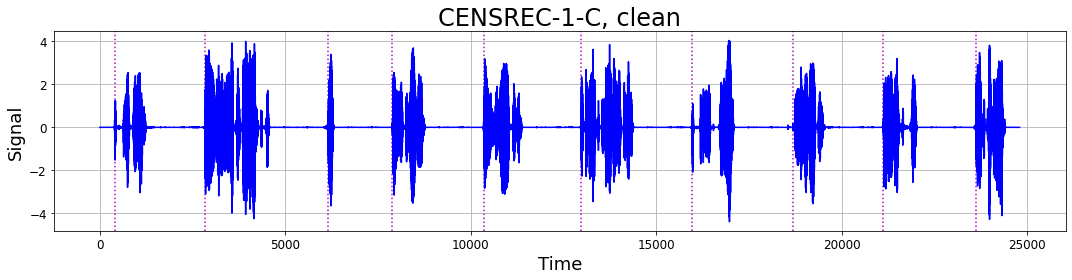

In [12]:
plt.figure(figsize=(15, 4))

for c in change_points:
    plt.axvline(c, c='m', ls=':')

plt.plot(np.arange(len(data)), data, c='b')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='CENSREC-1-C, clean', fontsize=24)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()
plt.tight_layout()


In [13]:
# Split the data into the stationary part, validation part, and test part

# Stationary part: three parts of the time series without the change points.
# Used to tune the threshold
#
data_stationary = [data[:390]]

# Validation part: a part with several change points to tune the hyperparameters
val_start = [300, 2720, 6050, 7800]
val_end = [500, 2920, 6250, 8000]
data_val = [data[val_start[i]:val_end[i]] for i in range(len(val_start))]

# Test part: check the performance of the procedures
test_start = [10250, 12870, 15850, 18580, 21020, 23520]
test_end = [10450, 13070, 16050, 18780, 21220, 23720]
data_test = [data[test_start[i]:test_end[i]] for i in range(len(test_start))]



In [14]:
change_points

array([  410,  2835,  6147,  7891, 10347, 12974, 15967, 18682, 21128,
       23620])

In [15]:
# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)

# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)

# Validation change points for plot
cpval = []
l = 0
for i in range(len(change_points_val)):
    cpval += [change_points_val[i] + l]
    l += data_val[0].shape[0]

# Validation data for plot
val_for_plot = np.hstack([data_val[i] for i in range(len(change_points_val))])


# Test change points for plot

cptest = []
l = 0
for i in range(len(change_points_test)):
    cptest += [change_points_test[i] + l]
    l += data_test[0].shape[0]

# Test data for plot
test_for_plot = np.hstack([data_test[i] for i in range(len(change_points_test))])


data_with_cps_for_plot = np.hstack([val_for_plot, test_for_plot])
cps = np.append(cpval, np.array(cptest)+800)
print('All change points: ', cps)

Validation change points: [110 115  97  91]
Test change points: [ 97 104 117 102 108 100]
All change points:  [ 110  315  497  691  897 1104 1317 1502 1708 1900]


### Score-based with quadratic basis $\Psi$

In [28]:
# The list of hyperparameters
eta_list = [0.01, 0.05, 0.1]
lambda_list = [0.1, 0.5, 1, 2, 5]
alpha_list = [1e-5, 1e-4, 1e-3, 1e-2]

# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
dim=1
for eta in eta_list:
    for l in lambda_list:
        for a in alpha_list:

            #----------------------------------------------------
            # Step 1: tuning the threshold on the stationary part
            #----------------------------------------------------
            S_stationary = np.empty(0)
            for ds in data_stationary:
                model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim))
                S, _ = model.run(ds.reshape(-1, 1), eta) 
                S_stationary = np.append(S_stationary, S)
                
            # Set the threshold as the maximal value on the stationary part
            z = np.max(S_stationary)
            print('threshold =', z)

            #----------------------------------------------------
            # Step 2: detect changes on the validation part
            #----------------------------------------------------
            
            # Initialization of the test statistic 
            S_q_list = np.empty((len(data_val), data_val[0].shape[0]))

            # Run the algorithm on whole segments (each has a single change point)
            for i in range(len(change_points_val)):
                model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim))
                new_S_q, _ = model.run(data_val[i].reshape(-1, 1), eta)  
                S_q_list[i] = new_S_q

            
            false_alarms_q, dd_mean_q, dd_std_q, not_detected_q = compute_delays_false_alarms(len(data_val), S_q_list, z, change_points_val)
            print(f'Score-based quadratic, threshold={z}, eta={eta}, lambda = {l}, alpha={a}', '. FA:', false_alarms_q,\
                            '; DD:', dd_mean_q, '±',dd_std_q,\
                            '; ND:', not_detected_q)


Validation change points: [110 115  97  91]
threshold = 0.0
108 0
Score-based quadratic, threshold=0.0, eta=0.01, lambda = 0.1, alpha=1e-05 . FA: 1 ; DD: 7.0 ± 4.5 ; ND: 0
threshold = 0.0
108 0
Score-based quadratic, threshold=0.0, eta=0.01, lambda = 0.1, alpha=0.0001 . FA: 1 ; DD: 7.0 ± 4.5 ; ND: 0
threshold = 0.0
108 0
Score-based quadratic, threshold=0.0, eta=0.01, lambda = 0.1, alpha=0.001 . FA: 1 ; DD: 7.0 ± 4.5 ; ND: 0
threshold = 0.0
108 0
Score-based quadratic, threshold=0.0, eta=0.01, lambda = 0.1, alpha=0.01 . FA: 1 ; DD: 7.7 ± 5.4 ; ND: 0
threshold = 0.0
Score-based quadratic, threshold=0.0, eta=0.01, lambda = 0.5, alpha=1e-05 . FA: 0 ; DD: 12.5 ± 5.4 ; ND: 0
threshold = 0.0
Score-based quadratic, threshold=0.0, eta=0.01, lambda = 0.5, alpha=0.0001 . FA: 0 ; DD: 12.0 ± 4.6 ; ND: 0
threshold = 0.0
Score-based quadratic, threshold=0.0, eta=0.01, lambda = 0.5, alpha=0.001 . FA: 0 ; DD: 12.5 ± 5.4 ; ND: 0
threshold = 0.0
Score-based quadratic, threshold=0.0, eta=0.01, lambda = 0

In [26]:
# The list of hyperparameters
eta_list = [ 0.1]
lambda_list = [0.2, 0.3]
alpha_list = [1e-5, 1e-4, 1e-3]

# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
dim=1
for eta in eta_list:
    for l in lambda_list:
        for a in alpha_list:

            #----------------------------------------------------
            # Step 1: tuning the threshold on the stationary part
            #----------------------------------------------------
            S_stationary = np.empty(0)
            for ds in data_stationary:
                model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim))
                S, _ = model.run(ds.reshape(-1, 1), eta) 
                S_stationary = np.append(S_stationary, S)
                
            # Set the threshold as the maximal value on the stationary part
            z = np.max(S_stationary)
            print('threshold =', z)

            #----------------------------------------------------
            # Step 2: detect changes on the validation part
            #----------------------------------------------------
            
            # Initialization of the test statistic 
            S_q_list = np.empty((len(data_val), data_val[0].shape[0]))

            # Run the algorithm on whole segments (each has a single change point)
            for i in range(len(change_points_val)):
                model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim))
                new_S_q, _ = model.run(data_val[i].reshape(-1, 1), eta)  
                S_q_list[i] = new_S_q

            
            false_alarms_q, dd_mean_q, dd_std_q, not_detected_q = compute_delays_false_alarms(len(data_val), S_q_list, z, change_points_val)
            print(f'Score-based quadratic, threshold={z}, eta={eta}, lambda = {l}, alpha={a}', '. FA:', false_alarms_q,\
                            '; DD:', dd_mean_q, '±',dd_std_q,\
                            '; ND:', not_detected_q)
           

Validation change points: [110 115  97  91]
threshold = 0.0
99 0
Score-based quadratic, threshold=0.0, eta=0.1, lambda = 0.2, alpha=1e-05 . FA: 1 ; DD: 1.0 ± 0.8 ; ND: 0
threshold = 0.0
99 0
Score-based quadratic, threshold=0.0, eta=0.1, lambda = 0.2, alpha=0.0001 . FA: 1 ; DD: 1.0 ± 0.8 ; ND: 0
threshold = 0.0
99 0
Score-based quadratic, threshold=0.0, eta=0.1, lambda = 0.2, alpha=0.001 . FA: 1 ; DD: 3.0 ± 2.9 ; ND: 0
threshold = 0.0
99 0
Score-based quadratic, threshold=0.0, eta=0.1, lambda = 0.3, alpha=1e-05 . FA: 1 ; DD: 3.0 ± 2.9 ; ND: 0
threshold = 0.0
99 0
Score-based quadratic, threshold=0.0, eta=0.1, lambda = 0.3, alpha=0.0001 . FA: 1 ; DD: 3.0 ± 2.9 ; ND: 0
threshold = 0.0
99 0
Score-based quadratic, threshold=0.0, eta=0.1, lambda = 0.3, alpha=0.001 . FA: 1 ; DD: 3.0 ± 2.9 ; ND: 0


In [16]:
# The list of hyperparameters
eta_list = [ 0.1]
lambda_list = [0.2]
alpha_list = [1e-5]

# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
dim=1
for eta in eta_list:
    for l in lambda_list:
        for a in alpha_list:

            #----------------------------------------------------
            # Step 1: tuning the threshold on the stationary part
            #----------------------------------------------------
            z = 1e-5
            print('threshold =', z)

            #----------------------------------------------------
            # Step 2: detect changes on the validation part
            #----------------------------------------------------
            
            # Initialization of the test statistic 
            S_q_list = np.empty((len(data_val), data_val[0].shape[0]))

            # Run the algorithm on whole segments (each has a single change point)
            for i in range(len(change_points_val)):
                model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim))
                new_S_q, _ = model.run(data_val[i].reshape(-1, 1), eta)  
                S_q_list[i] = new_S_q

            
            false_alarms_q, dd_mean_q, dd_std_q, not_detected_q = compute_delays_false_alarms(len(data_val), S_q_list, z, change_points_val)
            print(f'Score-based quadratic, threshold={z}, eta={eta}, lambda = {l}, alpha={a}', '. FA:', false_alarms_q,\
                            '; DD:', dd_mean_q, '±',dd_std_q,\
                            '; ND:', not_detected_q)
s_q_train = np.hstack(S_q_list)

Validation change points: [110 115  97  91]
threshold = 1e-05
99 0
Score-based quadratic, threshold=1e-05, eta=0.1, lambda = 0.2, alpha=1e-05 . FA: 1 ; DD: 1.0 ± 0.8 ; ND: 0


In [17]:

#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

# The list of hyperparameters
eta = 0.1
l = 0.2
a = 1e-5
z = 1e-5

# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)

dim=1
# Initialization of the test statistic 
S_q_list = np.empty((len(data_test), data_test[0].shape[0]))

# Run the algorithm on whole segments (each has a single change point)
for i in range(len(change_points_test)):
    model = ChangePointDetector(d_dim=dim*2, x_dim=dim, lambda_=l, alpha=a, basis=PolyBasis(2, dim))
    new_S_q, _ = model.run(data_test[i].reshape(-1, 1), eta)  
    S_q_list[i] = new_S_q


false_alarms_q, dd_mean_q, dd_std_q, not_detected_q = compute_delays_false_alarms(len(data_test), S_q_list, z, change_points_test)
print(f'Score-based quadratic, threshold={z}, eta={eta}, lambda = {l}, alpha={a}', '. FA:', false_alarms_q,\
                '; DD:', dd_mean_q, '±',dd_std_q,\
                '; ND:', not_detected_q)

s_q_test = np.hstack(S_q_list)


Test change points: [ 97 104 117 102 108 100]
115 2
Score-based quadratic, threshold=1e-05, eta=0.1, lambda = 0.2, alpha=1e-05 . FA: 1 ; DD: 1.0 ± 0.6 ; ND: 0


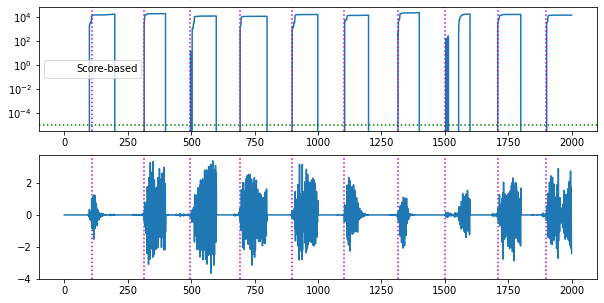

In [18]:
# Plot the test statistic on train and test sets
# Pink dotted lines correspond to true change points
S_q = np.append(s_q_train, s_q_test)
f, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].plot(S_q)
ax[0].set_yscale('log')
ax[0].axhline(z, c='g', ls=':')
for c in cps:
    ax[0].axvline(c, c='m', ls=':')
    ax[1].axvline(c, c='m', ls=':')
ax[0].plot(0, lw=0, label="Score-based")
ax[1].plot(data_with_cps_for_plot)
ax[0].legend()
plt.show()


### FALCON

In [2]:
# The list of hyperparameters
p_list = [ 3, 4, 5, 6]
beta_list = [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 2.5, 5, 7]

# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
dim=1
for p in p_list:
    for b in beta_list:
        #----------------------------------------------------
        # Step 1: tuning the threshold on the stationary part
        #----------------------------------------------------
        S_stationary = np.empty(0)
        for ds in data_stationary:
            S, _ = compute_test_stat_ftal(ds, p, beta=b, design='hermite')
            S_stationary = np.append(S_stationary, S)
            
        # Set the threshold as the maximal value on the stationary part
        z = np.maximum(np.max(S_stationary), 0.01)
        print('threshold =', z)

        #----------------------------------------------------
        # Step 2: detect changes on the validation part
        #----------------------------------------------------

        # Initialization of the test statistic 
        S_ftal_list = np.empty((len(data_val), data_val[0].shape[0]))

        # Run the algorithm on whole segments (each has a single change point)
        for i in range(len(change_points_val)):
            new_S_ftal, _ = compute_test_stat_ftal(data_val[i], p, beta=b, design='hermite')
            S_ftal_list[i] = new_S_ftal

        false_alarms_ftal, dd_mean_ftal, dd_std_ftal, not_detected_ftal = compute_delays_false_alarms(len(data_val), S_ftal_list, z, change_points_val)
        print(f'FTAL, beta = {b}, p={p}', '. Number of false alarms:', false_alarms_ftal,\
                '; average delay:', dd_mean_ftal, '±', dd_std_ftal,\
                '; non-detected:', not_detected_ftal)

s_ftal_train = np.hstack(S_ftal_list)

Validation change points: [110 115  97  91]
threshold = 0.4381171925428283
100 0
31 3
FTAL, beta = 0.005, p=3 . Number of false alarms: 2 ; average delay: 0.5 ± 0.5 ; non-detected: 0
threshold = 0.2667131509960947
30 0
113 1
58 2
29 3
FTAL, beta = 0.01, p=3 . Number of false alarms: 4 ; average delay: nan ± nan ; non-detected: 0
threshold = 0.17236064723344238
99 0
107 1
57 2
72 3
FTAL, beta = 0.02, p=3 . Number of false alarms: 4 ; average delay: nan ± nan ; non-detected: 0
threshold = 0.21620159933357266
99 0
110 1
57 2
88 3
FTAL, beta = 0.05, p=3 . Number of false alarms: 4 ; average delay: nan ± nan ; non-detected: 0
threshold = 0.21065110878336923
99 0
113 1
90 3
FTAL, beta = 0.1, p=3 . Number of false alarms: 3 ; average delay: 1.0 ± 0.0 ; non-detected: 0
threshold = 0.22278318897880436
99 0
113 1
90 3
FTAL, beta = 0.2, p=3 . Number of false alarms: 3 ; average delay: 7.0 ± 0.0 ; non-detected: 0
threshold = 0.2210276824500107
109 0
114 1
72 3
FTAL, beta = 0.5, p=3 . Number of fal

In [19]:
# The list of hyperparameters
p_list = [5]
beta_list = [0.2]

# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
dim=1
for p in p_list:
    for b in beta_list:
        #----------------------------------------------------
        # Step 1: tuning the threshold on the stationary part
        #----------------------------------------------------
        
        z = 0.7181051648770866
        print('threshold =', z)

        #----------------------------------------------------
        # Step 2: detect changes on the validation part
        #----------------------------------------------------

        # Initialization of the test statistic 
        S_ftal_list = np.empty((len(data_val), data_val[0].shape[0]))

        # Run the algorithm on whole segments (each has a single change point)
        for i in range(len(change_points_val)):
            new_S_ftal, _ = compute_test_stat_ftal(data_val[i], p, beta=b, design='hermite')
            S_ftal_list[i] = new_S_ftal

        false_alarms_ftal, dd_mean_ftal, dd_std_ftal, not_detected_ftal = compute_delays_false_alarms(len(data_val), S_ftal_list, z, change_points_val)
        print(f'FTAL, beta = {b}, p={p}', '. Number of false alarms:', false_alarms_ftal,\
                '; average delay:', dd_mean_ftal, '±', dd_std_ftal,\
                '; non-detected:', not_detected_ftal)

s_ftal_train = np.hstack(S_ftal_list)

Validation change points: [110 115  97  91]
threshold = 0.7181051648770866
100 0
FTAL, beta = 0.2, p=5 . Number of false alarms: 1 ; average delay: 3.3 ± 2.6 ; non-detected: 0


In [20]:
#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

# The list of hyperparameters
b = 0.2
z = 0.7181051648770866
p=5

# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)
    

# Initialization of the test statistic
S_ftal_list = np.empty((len(data_test), data_test[0].shape[0]))


# Run the algorithm on whole segments (each has a single change point)
for i in range(len(change_points_test)):
    new_S_ftal, _ = compute_test_stat_ftal(data_test[i], p, beta=b,\
                                                    design='hermite')
    S_ftal_list[i] = new_S_ftal

fa_ftal, dd_mean_ftal, dd_std_ftal, not_detected_ftal = compute_delays_false_alarms(len(data_test), S_ftal_list, z, change_points_test)

print(f'FTAL, beta = {b}, p={p}', '. Number of false alarms:', fa_ftal,\
    '; average delay:', dd_mean_ftal, '±', dd_std_ftal,\
    '; non-detected:', not_detected_ftal)

s_ftal_test = np.hstack(S_ftal_list)

Test change points: [ 97 104 117 102 108 100]
FTAL, beta = 0.2, p=5 . Number of false alarms: 0 ; average delay: 7.8 ± 14.4 ; non-detected: 0


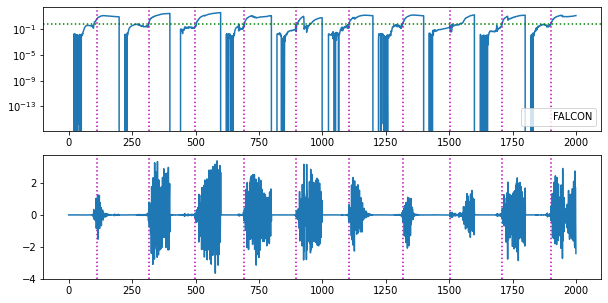

In [21]:
# Plot the test statistic on train and test sets
# Pink dotted lines correspond to true change points
S_ftal = np.append(s_ftal_train, s_ftal_test)
f, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].plot(S_ftal)
ax[0].set_yscale('log')
ax[0].axhline(z, c='g', ls=':')
for c in cps:
    ax[0].axvline(c, c='m', ls=':')
    ax[1].axvline(c, c='m', ls=':')
ax[0].plot(0, lw=0, label="FALCON")
ax[1].plot(data_with_cps_for_plot)
ax[0].legend()
plt.show()


### KLIEP

In [60]:
# The list of hyperparameters
sigma_list = [0.01, 0.02, 0.025, 0.05, 0.075, 0.1, 0.2, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 2]

# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
    
for sigma in sigma_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------

    S_stationary = np.empty(0)
    for ds in data_stationary:
        S, _ = compute_test_stat_kliep(ds, window_size=50, sigma=sigma)
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.round(np.max(S_stationary), 4)
    print('sigma =', sigma, ', threshold =', z)
    
    
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------
    
    # Initialization of the test statistic
    S_kliep_list = np.empty((len(data_val), data_val[0].shape[0]))

    # Run the algorithm on whole segments (each has a single change point)
    for i in range(len(change_points_val)):
        new_S_kliep, _ = compute_test_stat_kliep(data_val[i], window_size=50, sigma=sigma)
        S_kliep_list[i] = new_S_kliep

    fa_kliep, dd_mean_kliep, dd_std_kliep, not_detected_kliep = compute_delays_false_alarms(len(data_val), S_kliep_list, z, change_points_val)

    print(f'KlIEP, sigma = {sigma}', '. Number of false alarms:', fa_kliep,\
        '; average delay:', dd_mean_kliep, '±', dd_std_kliep,\
        '; non-detected:', not_detected_kliep)

    s_kliep_train = np.hstack(S_kliep_list)


Validation change points: [110 115  97  91]
sigma = 0.01 , threshold = 2.2782
101 0
101 1
KlIEP, sigma = 0.01 . Number of false alarms: 2 ; average delay: 7.0 ± 3.0 ; non-detected: 0
sigma = 0.02 , threshold = 0.6171
101 0
101 1
KlIEP, sigma = 0.02 . Number of false alarms: 2 ; average delay: 7.0 ± 3.0 ; non-detected: 0
sigma = 0.025 , threshold = 0.4034
101 0
101 1
KlIEP, sigma = 0.025 . Number of false alarms: 2 ; average delay: 7.0 ± 3.0 ; non-detected: 0
sigma = 0.05 , threshold = 0.0983
101 0
109 1
KlIEP, sigma = 0.05 . Number of false alarms: 2 ; average delay: 7.0 ± 3.0 ; non-detected: 0
sigma = 0.075 , threshold = 0.0417
101 0
113 1
KlIEP, sigma = 0.075 . Number of false alarms: 2 ; average delay: 7.0 ± 3.0 ; non-detected: 0
sigma = 0.1 , threshold = 0.023
101 0
115 1
KlIEP, sigma = 0.1 . Number of false alarms: 2 ; average delay: 7.0 ± 3.0 ; non-detected: 0
sigma = 0.2 , threshold = 0.0045
101 0
KlIEP, sigma = 0.2 . Number of false alarms: 1 ; average delay: 6.0 ± 3.7 ; non-de

In [22]:
# The list of hyperparameters
sigma_list = [1]

# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
    
for sigma in sigma_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------

    z = 0
    print('threshold =', z)
    
    
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------
    
    # Initialization of the test statistic
    S_kliep_list = np.empty((len(data_val), data_val[0].shape[0]))

    # Run the algorithm on whole segments (each has a single change point)
    for i in range(len(change_points_val)):
        new_S_kliep, _ = compute_test_stat_kliep(data_val[i], window_size=50, sigma=sigma)
        S_kliep_list[i] = new_S_kliep

    fa_kliep, dd_mean_kliep, dd_std_kliep, not_detected_kliep = compute_delays_false_alarms(len(data_val), S_kliep_list, z, change_points_val)

    print(f'KlIEP, sigma = {sigma}', '. Number of false alarms:', fa_kliep,\
        '; average delay:', dd_mean_kliep, '±', dd_std_kliep,\
        '; non-detected:', not_detected_kliep)

    s_kliep_train = np.hstack(S_kliep_list)


Validation change points: [110 115  97  91]
threshold = 0
KlIEP, sigma = 1 . Number of false alarms: 0 ; average delay: 6.2 ± 3.3 ; non-detected: 0


In [23]:
#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)
    
sigma = 1
z = 0

# Initialization of the test statistic
S_kliep_list = np.empty((len(data_test), data_test[0].shape[0]))

# Run the algorithm on whole segments (each has a single change point)
for i in range(len(change_points_test)):
    new_S_kliep, _ = compute_test_stat_kliep(data_test[i], window_size=50, sigma=sigma)
    S_kliep_list[i] = new_S_kliep

fa_kliep, dd_mean_kliep, dd_std_kliep, not_detected_kliep = compute_delays_false_alarms(len(data_test), S_kliep_list, z, change_points_test)

print(f'KlIEP, sigma = {sigma}', '. Number of false alarms:', fa_kliep,\
    '; average delay:', dd_mean_kliep, '±', dd_std_kliep,\
    '; non-detected:', not_detected_kliep)

s_kliep_test = np.hstack(S_kliep_list)


Test change points: [ 97 104 117 102 108 100]
101 3
KlIEP, sigma = 1 . Number of false alarms: 1 ; average delay: 6.2 ± 4.9 ; non-detected: 0


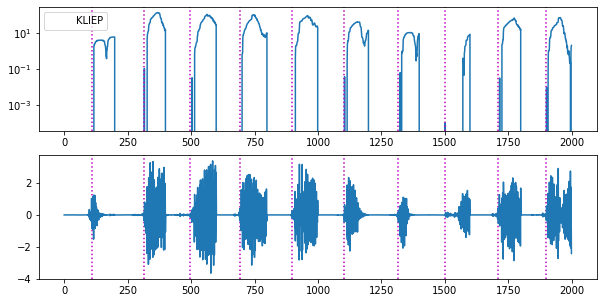

In [24]:
# Plot the test statistic on train and test sets
# Pink dotted lines correspond to true change points
S_kliep = np.append(s_kliep_train, s_kliep_test)
f, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].plot(S_kliep)
ax[0].set_yscale('log')
ax[0].axhline(z, c='g', ls=':')
for c in cps:
    ax[0].axvline(c, c='m', ls=':')
    ax[1].axvline(c, c='m', ls=':')
ax[0].plot(0, lw=0, label="KLIEP")
ax[1].plot(data_with_cps_for_plot)
ax[0].legend()
plt.show()


### M-statistic

In [107]:
# The list of hyperparameters
sigma_list = [0.01, 0.02, 0.025, 0.05, 0.075, 0.1, 0.2, 0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 5]

# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
    
for sigma in sigma_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------

    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_test_stat_mmd(ds, window_size=50, sigma=sigma)
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.max(S_stationary) + 0.1
    print('sigma =', sigma, ', threshold =', z)
    
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------

    # Initialization of the test statistic
    S_mmd_list = np.empty((len(data_val), data_val[0].shape[0]))

    # Run the algorithm on whole segments (each has a single change point)
    for i in range(len(change_points_val)):
        new_S_mmd, _ = compute_test_stat_mmd(data_val[i], window_size=50, sigma=sigma)
        S_mmd_list[i] = new_S_mmd

    fa_mmd, dd_mean_mmd, dd_std_mmd, not_detected_mmd = compute_delays_false_alarms(len(data_val), S_mmd_list, z, change_points_val)

    print(f'M-statistic, sigma = {sigma}', '. Number of false alarms:', fa_mmd,\
        '; average delay:', dd_mean_mmd, '±', dd_std_mmd,\
        '; non-detected:', not_detected_mmd)


Validation change points: [110 115  97  91]
sigma = 0.01 , threshold = 7.707599313418759
101 0
101 1
M-statistic, sigma = 0.01 . Number of false alarms: 2 ; average delay: 7.0 ± 3.0 ; non-detected: 0
sigma = 0.02 , threshold = 2.073681936031859
101 0
101 1
M-statistic, sigma = 0.02 . Number of false alarms: 2 ; average delay: 7.0 ± 3.0 ; non-detected: 0
sigma = 0.025 , threshold = 1.36884541067294
101 0
101 1
M-statistic, sigma = 0.025 . Number of false alarms: 2 ; average delay: 7.0 ± 3.0 ; non-detected: 0
sigma = 0.05 , threshold = 0.4191227968337945
101 0
101 1
M-statistic, sigma = 0.05 . Number of false alarms: 2 ; average delay: 7.0 ± 3.0 ; non-detected: 0
sigma = 0.075 , threshold = 0.2419905236279644
101 0
104 1
M-statistic, sigma = 0.075 . Number of false alarms: 2 ; average delay: 7.0 ± 3.0 ; non-detected: 0
sigma = 0.1 , threshold = 0.1799008445796409
101 0
109 1
M-statistic, sigma = 0.1 . Number of false alarms: 2 ; average delay: 7.0 ± 3.0 ; non-detected: 0
sigma = 0.2 , th

In [27]:
# The list of hyperparameters
sigma_list = [0.25]

# Change points on the validation set
change_points_val = change_points[change_points < val_end[-1]] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
    
for sigma in sigma_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------

    z = 0.1127895254842545
    print('threshold =', z)
    
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------

    # Initialization of the test statistic
    S_mmd_list = np.empty((len(data_val), data_val[0].shape[0]))

    # Run the algorithm on whole segments (each has a single change point)
    for i in range(len(change_points_val)):
        new_S_mmd, _ = compute_test_stat_mmd(data_val[i], window_size=50, sigma=sigma)
        S_mmd_list[i] = new_S_mmd

    fa_mmd, dd_mean_mmd, dd_std_mmd, not_detected_mmd = compute_delays_false_alarms(len(data_val), S_mmd_list, z, change_points_val)

    print(f'M-statistic, sigma = {sigma}', '. Number of false alarms:', fa_mmd,\
        '; average delay:', dd_mean_mmd, '±', dd_std_mmd,\
        '; non-detected:', not_detected_mmd)
s_mmd_train = np.hstack(S_mmd_list)

Validation change points: [110 115  97  91]
threshold = 0.1127895254842545
101 0
M-statistic, sigma = 0.25 . Number of false alarms: 1 ; average delay: 5.0 ± 3.7 ; non-detected: 0


In [26]:
#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

sigma = 0.25
z = 0.1127895254842545


# Change points on the test set
change_points_test = change_points[change_points < test_end[-1]] 
change_points_test = change_points_test[change_points_test > test_start[0]] - test_start
print('Test change points:', change_points_test)
    

# Initialization of the test statistic
S_mmd_list = np.empty((len(data_test), data_test[0].shape[0]))

# Run the algorithm on whole segments (each has a single change point)
for i in range(len(change_points_test)):
    new_S_mmd, _ = compute_test_stat_mmd(data_test[i], window_size=50, sigma=sigma)
    S_mmd_list[i] = new_S_mmd

fa_mmd, dd_mean_mmd, dd_std_mmd, not_detected_mmd = compute_delays_false_alarms(len(data_test), S_mmd_list, z, change_points_test)

print(f'M-statistic, sigma = {sigma}', '. Number of false alarms:', fa_mmd,\
    '; average delay:', dd_mean_mmd, '±', dd_std_mmd,\
    '; non-detected:', not_detected_mmd)

s_mmd_test = np.hstack(S_mmd_list)



Test change points: [ 97 104 117 102 108 100]
M-statistic, sigma = 0.25 . Number of false alarms: 0 ; average delay: 2.5 ± 3.2 ; non-detected: 0


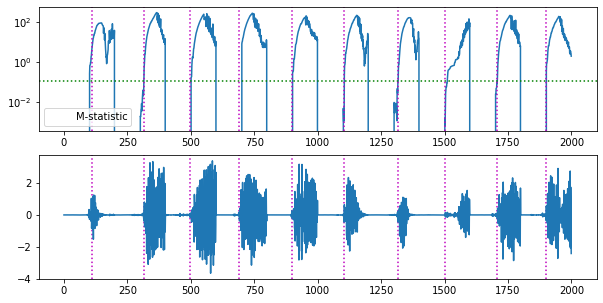

In [28]:
# Plot the test statistic on train and test sets
# Pink dotted lines correspond to true change points
S_mmd = np.append(s_mmd_train, s_mmd_test)
f, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].plot(S_mmd)
ax[0].set_yscale('log')
ax[0].axhline(z, c='g', ls=':')
for c in cps:
    ax[0].axvline(c, c='m', ls=':')
    ax[1].axvline(c, c='m', ls=':')
ax[0].plot(0, lw=0, label="M-statistic")
ax[1].plot(data_with_cps_for_plot)
ax[0].legend()
plt.show()
